In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [10]:
import numpy as np
import pandas as pd

from scipy.stats import skew, kurtosis

In [8]:
data = pd.read_csv("/disk2/fli/SSMuLA/data/DHFR/scale2max/DHFR.csv")["fitness"]
data

0       0.126525
1       0.123933
2       0.123492
3       0.125148
4       0.124846
          ...   
9256    0.128348
9257    0.126103
9258    0.127120
9259    0.122598
9260    0.125158
Name: fitness, Length: 9261, dtype: float64

In [15]:
mean = np.mean(data)
median = np.median(data)

# Variability
range_ = np.max(data) - np.min(data)
iqr = np.percentile(data, 75) - np.percentile(data, 25)
std_dev = np.std(data)
variance = np.var(data)

# shape
skewness = skew(data)
kurt = kurtosis(data)

quartiles = data.quantile([0.25, 0.5, 0.75]).to_list()

print("Mean:", mean)
print("Median:", median)

print("Range:", range_)
print("Interquartile Range (IQR):", iqr)
print("Standard Deviation:", std_dev)
print("Variance:", variance)

print("Skewness:", skewness)
print("Kurtosis:", kurt)

print("Quartiles:", quartiles)


Mean: 0.15399998326071415
Median: 0.1272733976451728
Range: 0.8848338582661568
Interquartile Range (IQR): 0.0037126242384240005
Standard Deviation: 0.10405442936294833
Variance: 0.010827324270048804
Skewness: 4.661061923959452
Kurtosis: 22.79745261636328
Quartiles: [0.1257141164729059, 0.1272733976451728, 0.1294267407113299]


In [16]:
import matplotlib.pyplot as plt
from scipy.stats import cauchy

In [17]:
loc, scale = cauchy.fit(data)

In [18]:
loc, scale

(0.12687860331717168, 0.0016960089074327064)

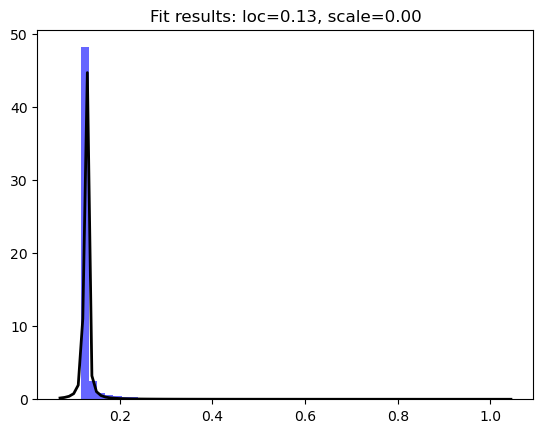

In [19]:
# Plot histogram of data
plt.hist(data, bins=50, density=True, alpha=0.6, color='b')

# Plot fitted Cauchy distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = cauchy.pdf(x, loc=loc, scale=scale)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Fit results: loc=%.2f, scale=%.2f' % (loc, scale))
plt.show()


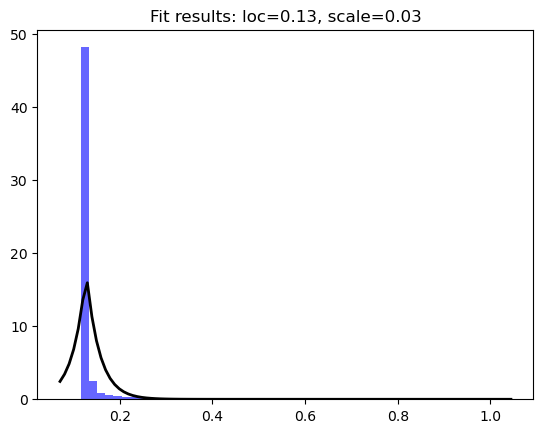

In [20]:
from scipy.stats import laplace

# Fit the Laplace distribution to the data
loc, scale = laplace.fit(data)

# Plot histogram of data
plt.hist(data, bins=50, density=True, alpha=0.6, color='b')

# Plot fitted Laplace distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = laplace.pdf(x, loc=loc, scale=scale)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Fit results: loc=%.2f, scale=%.2f' % (loc, scale))
plt.show()


In [22]:
kde

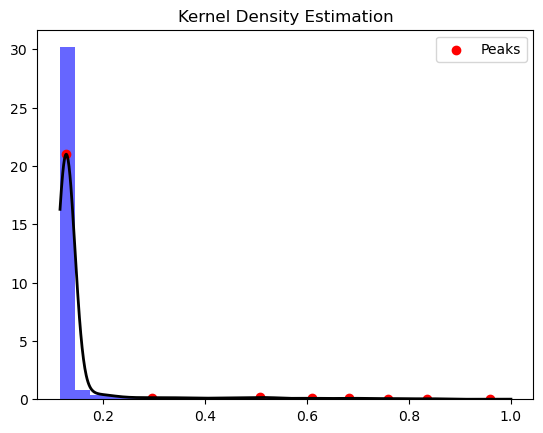

Peaks: [0.12756622 0.29585294 0.50753991 0.60939767 0.68202667 0.75908427
 0.83525616 0.95837118]
Percentiles: [0.1151661417338432, 0.12126173777622398, 0.12216987336590056, 0.12268741036718508, 0.12309855750025632, 0.1234313026819342, 0.12369312686269916, 0.12390512835242194, 0.12408028418051611, 0.12423969373751902, 0.1243762671913482, 0.12452230747589248, 0.12464466415993583, 0.12473363582737683, 0.12481933651392721, 0.1249015761341488, 0.12500820574732424, 0.12510853641468805, 0.12519645966301896, 0.12528365568975505, 0.1253611364801385, 0.12542623014587442, 0.1254986536394081, 0.12556877427265453, 0.1256433478874549, 0.1257141164729059, 0.12578897266586753, 0.12584691210981586, 0.12590948613994987, 0.12597950032375857, 0.126051677363897, 0.12610753280402048, 0.12616344375363878, 0.12622887217717038, 0.1262889754368095, 0.1263487022142829, 0.12641383853035032, 0.1264676905361566, 0.12652929740748584, 0.12658949663632918, 0.126652423168973, 0.12672156207028248, 0.12678640216091314, 

In [24]:
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

# Estimate PDF using kernel density estimation (KDE)
kde = gaussian_kde(data)

# Evaluate PDF on a grid of points
x_grid = np.linspace(np.min(data), np.max(data), 1000)
pdf_values = kde(x_grid)

# Find peaks (local maxima)
peaks = x_grid[argrelextrema(pdf_values, np.greater)[0]]

# Estimate percentiles
percentiles = [np.percentile(data, p) for p in range(0, 101)]

# Plot histogram of data
plt.hist(data, bins=30, density=True, alpha=0.6, color='b')

# Plot KDE estimate
plt.plot(x_grid, pdf_values, 'k-', linewidth=2)

# Mark peaks
plt.scatter(peaks, kde(peaks), color='red', marker='o', label='Peaks')

plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

print("Peaks:", peaks)
print("Percentiles:", percentiles)


In [ ]:
def de_violin(
    slice_df: pd.DataFrame,
    lib_name: str,
    plot_name: str,
    plot_folder: str,
    v_width: int = 400,
):

    """
    A function to plot a violin plot of the DE simulation results

    Args:
    - slice_df (pd.DataFrame): A dataframe containing the DE simulation results
    - lib_name (str): The name of the library to plot
    - plot_name (str): The name of the plot
    - plot_folder (str): The folder to save the plot
    - v_width (int): Width of the violin plot
    """

    print(f"Plotting DE max fitness achieved violin...")

    if lib_name == "TrpB":
        v_width = 1280
        cmap = [LIB_COLORS[lib_name] for lib_name in TrpB_names]
        xrotation = 45
    else:
        v_width = 400
        cmap = [LIB_COLORS[lib_name]]
        xrotation = 0

    violin = hv.Violin(
        slice_df,
        kdims=["simulation", "lib"],
        vdims=["final_fitness"],
    ).opts(
        violin_color=dim("lib").str(),
        cmap=cmap,
        width=v_width,
        height=300,
        violin_width=0.8,
        title=plot_name,
        hooks=[fixmargins, one_decimal_y],
        ylabel="Max fitness achieved",
        xrotation=xrotation,
    )

    save_bokeh_hv(
        violin,
        plot_name=plot_name,
        plot_path=checkNgen_folder(os.path.join(plot_folder, "violin")),
        bokehorhv="hv",
        dpi=300,
        scale=2,
    )

    return violin